
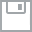
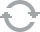
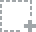
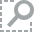
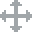
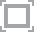
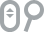
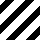
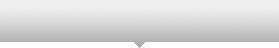
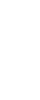
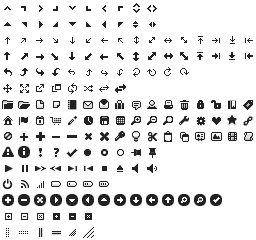
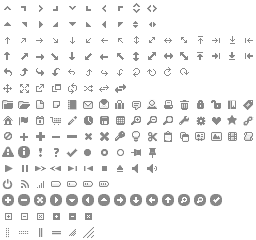
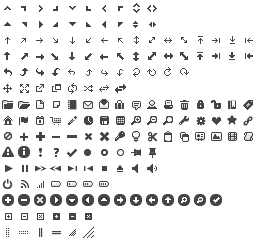
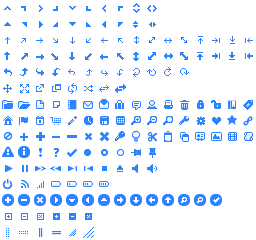
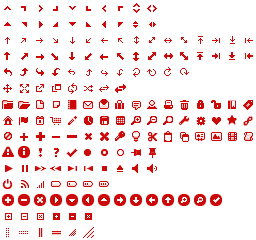
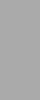
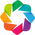
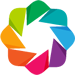

In [292]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize

# Numerical differentiation packages
import numdifftools as ndt

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Bokeh stuff
import bokeh.charts
import bokeh.io

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Display graphics in this notebook
bokeh.io.output_notebook()


## 2A
The Gaussian distribution was probably chosen because it was simple.  It is not horribly wrong; the plot shown in the problem statement looks vaguely Gaussian.
There is no reason to assume that fluorescence should form a discontinuous gradient, and so the binomial distribution is not appropriate
Let's do a little plotting to make sure that it still looks Gaussian.

In [293]:
# Load data
df = pd.read_csv('data/reeves_dv_profile_over_time.csv', comment='#')

# Check it out
df.head()

,DV coord nc 14,fluor intensity nc 14,DV coord nc 13,fluor intensity nc 13,DV coord nc 12,fluor intensity nc 12,DV coord nc 11,fluor intensity nc 11
0,0.7813,1.6512,0.7939,1.6763,0.9210,1.0523,0.9347,1.2730
1,0.8565,1.4200,0.8404,1.1663,-0.5801,1.4345,-0.9663,1.1778
2,0.8986,1.3845,0.8789,1.3919,-0.5192,1.2087,-0.5628,1.2967
3,0.9286,1.3960,0.9879,1.2993,-0.4795,1.2272,-0.3528,1.4155
4,-0.9356,1.1741,-0.9231,1.2076,-0.3491,1.4272,-0.1478,2.0224


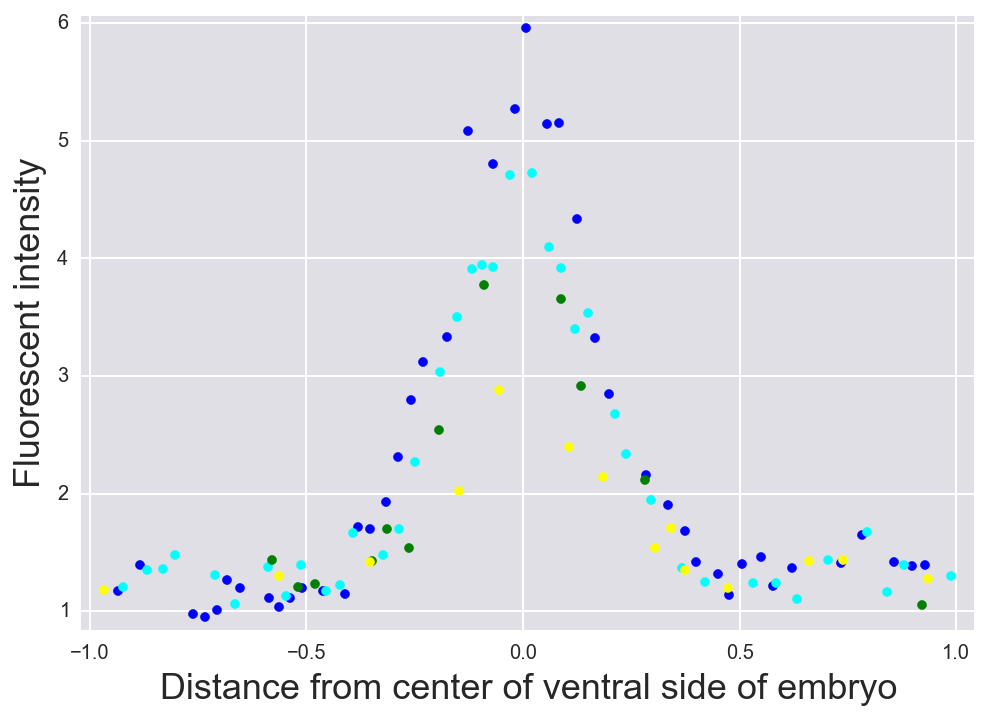

In [294]:
with sns.color_palette('rainbow_r'):
    legend_labels = []
    plt.scatter(df['DV coord nc 14'],df['fluor intensity nc 14'], color = 'blue')
    plt.scatter(df['DV coord nc 13'],df['fluor intensity nc 13'], color = 'cyan')
    plt.scatter(df['DV coord nc 12'],df['fluor intensity nc 12'], color = 'green')
    plt.scatter(df['DV coord nc 11'],df['fluor intensity nc 11'], color = 'yellow')


plt.margins(y=0.02)
plt.margins(x=0.02)
plt.xlabel('Distance from center of ventral side of embryo')
plt.ylabel('Fluorescent intensity')


## plotting conclusions for 2a
Yes, it looks reasonable to estimate these distributions as Gaussian, although they need to be corrected such that the fluorescence bottoms out at 0, and not 1.  (Just subtract 1 from all values)

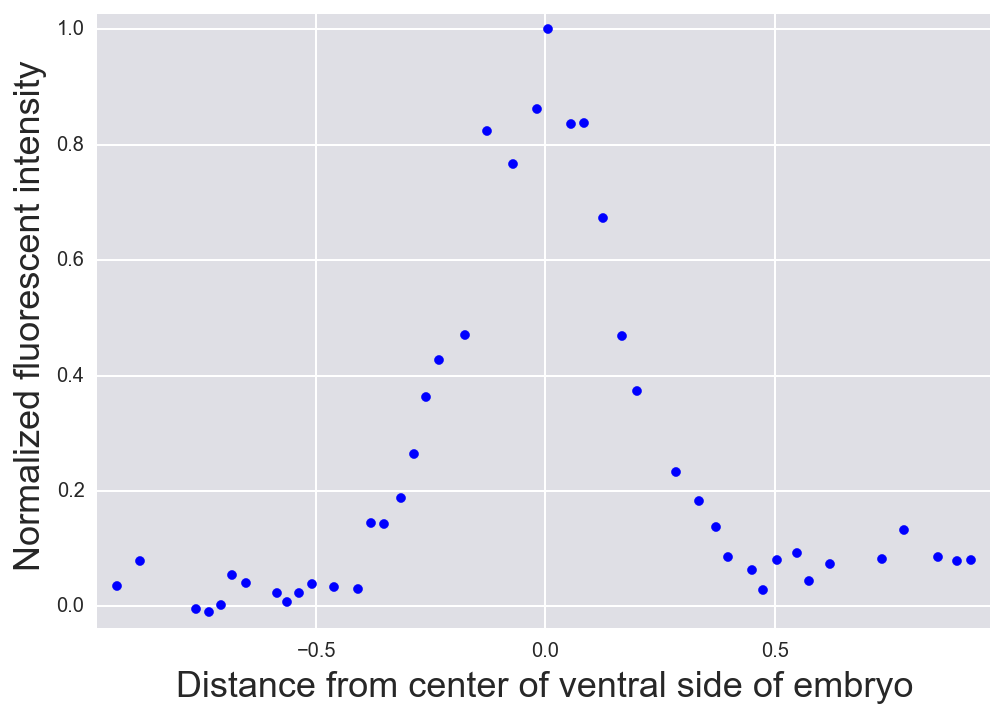

In [295]:
plt.scatter(df['DV coord nc 14'],((df['fluor intensity nc 14']-1)/ (np.max(df['fluor intensity nc 14'])-1)), color = 'blue')
plt.margins(y=0.02)
plt.margins(x=0.02)
plt.xlabel('Distance from center of ventral side of embryo')
plt.ylabel(' Normalized fluorescent intensity')


## 2 b
Below is the likelihood for a single parameter

\begin{align}
P(D \mid \mu, \sigma, I) = \prod_{i\in d} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left[-\frac{(x_i - \mu)^2}{2\sigma^2}\right].
\end{align}

We are not dealing with a single parameter.  We are attempting to model a Gaussian distribution, we need more parameters.  A Gaussian is decribed by the following equation:

\begin{align}
f(x; a,b,c) = a\exp\frac{-(x-b)^2}{2c^2}
\end{align}


Then the likelihood is expressed as

\begin{align}
P(D \mid a,b,c, \sigma, I) = \prod_{i\in D} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left[-\frac{(y_i - f(x_i,a,b,c)^2}{2\sigma^2}\right].
\end{align}



We assume uniform priors for $a$, $b$ and $c$ and a Jeffreys prior for $\sigma$.  The posterior is then

\begin{align}
P(a,b,c, \sigma \mid D, I) \propto\frac{1}{\sigma^{n+1}}
\exp\left[-\frac{1}{2\sigma^2}\sum_{i\in D}(y_i - f(x_i;a,b,c))^2\right],
\end{align}


Where

\begin{align}
f(x_i; a,b,c) = a\exp\frac{-(x-b)^2}{2c^2}
\end{align}


Now we can marginalize of $\sigma$, and get



\begin{align}
P(a,b,c \mid D, I) \propto \left(\sum_{i\in D}(y_i - f(x_i;a,b,c))^2\right)^{-\frac{n}{2}} .
\end{align}




## 2c

In [296]:
# If we are only trying to estimate width of the distribution, we can simplify the Gaussian model.  
# We can normalize the Gaussian, and thus get rid of the "a" parameter, and just call it 1.
# b is related to mu value
# c is related to sigma value


def gauss_dist(p, x):
    """
    Equation for a Gaussian distribution
    """
    b, c = p
    return np.exp(-((x-b)**2)/(2*(c**2)))

def log_post(p, x, y):
    """
    Compute log of posterior for single set of parameters.
    p[0] = b
    p[1] = c
    """
    # Unpack parameters
    b, c = p
    
    # Theoretical Gaussian
    y_theor = gauss_dist(p,x)
    
    return -len(x) / 2 * np.log(np.sum((y - y_theor)**2))


def resid(p, x, y):
    """
    Residuals for gaussian model.
    """
    return y - gauss_dist(p, x)



## Nuclear cycle 14

In [297]:
# Parameter values to plot
b = np.linspace(-.1, .1, 50)
c = np.linspace(.01, .5, 50)

# Make a grid
bb, cc = np.meshgrid(b, c)

# Compute log posterior
log_posterior = np.empty_like(bb)
for j in range(len(bb)):
    for i in range(len(cc)):
        log_posterior[i, j] = log_post(np.array([bb[i,j], cc[i,j]]),df['DV coord nc 14'],((df['fluor intensity nc 14']-1)/ (np.max(df['fluor intensity nc 14'])-1)))


# Initial guess
# b is the center of the distrubution, so we'll guess 0
# c is the spread
p0 = np.array([0, 0.4])

# Extra arguments as a tuple
args = (df['DV coord nc 14'],((df['fluor intensity nc 14']-1)/ (np.max(df['fluor intensity nc 14'])-1)))

# Compute the MAP
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)

# Extract the values
b,c = popt

# Print results
print("""
Nuclear cycle 14, most probable parameters
----------------------------------
b = {0:.3f} 
c = {1:.3f}
""".format(b, c))


Nuclear cycle 14, most probable parameters
----------------------------------
b = -0.013 
c = 0.164



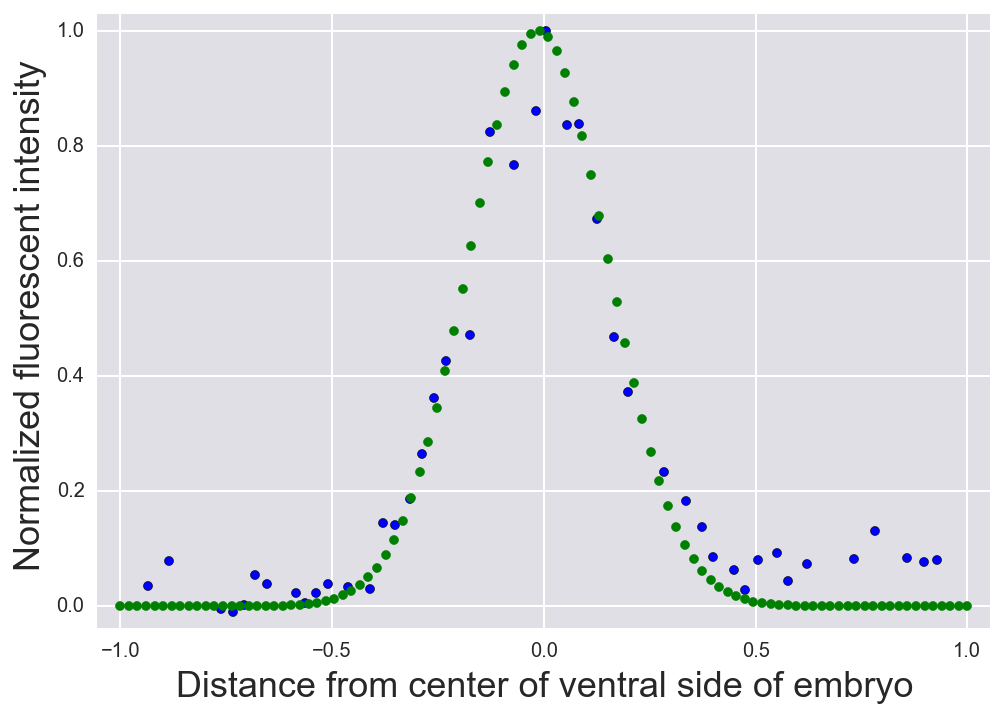

In [298]:
plt.scatter(df['DV coord nc 14'],((df['fluor intensity nc 14']-1)/ (np.max(df['fluor intensity nc 14'])-1)))
x = np.linspace(-1,1,100)
plt.scatter(x,gauss_dist(popt,x), color = 'green')
plt.margins(y=0.02)
plt.margins(x=0.02)
plt.xlabel('Distance from center of ventral side of embryo')
plt.ylabel(' Normalized fluorescent intensity')


In [299]:
# Instantiate Hessian for log posterior
hes_fun = ndt.Hessian(log_post)

# Compute Hessian at MAP
hes = hes_fun(popt, df['DV coord nc 14'],((df['fluor intensity nc 14']-1)/ (np.max(df['fluor intensity nc 14'])-1)))

# Compute the covariance matrix
cov = -np.linalg.inv(hes)

# Report results
print("""
Results for Nuclear cycle 14(≈ 68% of total probability)
------------------------------------------------
b = {0:.3f} ± {1:.3f}
c = {2:.3f} ± {3:.3f}
""".format(b, np.sqrt(cov[0,0]), c, np.sqrt(cov[1,1])))



Results for Nuclear cycle 14(≈ 68% of total probability)
------------------------------------------------
b = -0.013 ± 0.954
c = 0.164 ± 0.019



## Nuclear cycle 13

In [300]:
df_13 = pd.DataFrame({'DV coord nc 13': df['DV coord nc 13'], 'fluor intensity nc 13': (df['fluor intensity nc 13']-1)/ (np.max(df['fluor intensity nc 13'])-1)})
df_13 = df_13.dropna()

#Parameter values to plot
b = np.linspace(-.1, .1, 50)
c = np.linspace(.01, .5, 50)

# Make a grid
bb, cc = np.meshgrid(b, c)

# Compute log posterior
log_posterior = np.empty_like(bb)
for j in range(len(bb)):
    for i in range(len(cc)):
        log_posterior[i, j] = log_post(np.array([bb[i,j], cc[i,j]]), df_13['DV coord nc 13'], df_13['fluor intensity nc 13'])



# Initial guess
# b is the center of the distrubution, so we'll guess 0
# c is the spread
p0 = np.array([0, 0.2])

# Extra arguments as a tuple
args = (df_13['DV coord nc 13'],df_13['fluor intensity nc 13'])

# Compute the MAP
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)
# Extract the values
b,c = popt

# Print results
print("""
Nuclear cycle 13, most probable parameters
----------------------------------
b = {0:.3f} 
c = {1:.3f}
""".format(b, c))


Nuclear cycle 13, most probable parameters
----------------------------------
b = -0.003 
c = 0.166



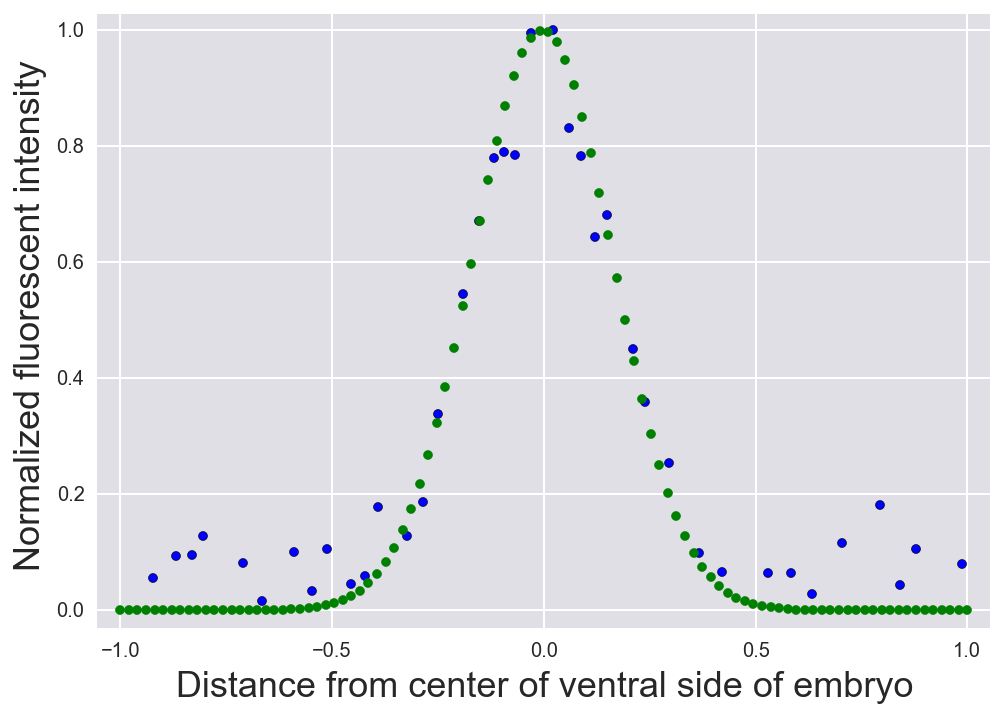

In [301]:
plt.scatter(df['DV coord nc 13'],((df['fluor intensity nc 13']-1)/ (np.max(df['fluor intensity nc 13'])-1)))
x = np.linspace(-1,1,100)
plt.scatter(x,gauss_dist(popt,x), color = 'green')
plt.margins(y=0.02)
plt.margins(x=0.02)
plt.xlabel('Distance from center of ventral side of embryo')
plt.ylabel(' Normalized fluorescent intensity')


In [302]:
# Instantiate Hessian for log posterior
hes_fun = ndt.Hessian(log_post)

# Compute Hessian at MAP
hes = hes_fun(popt, df_13['DV coord nc 13'],df_13['fluor intensity nc 13'])

# Compute the covariance matrix
cov = -np.linalg.inv(hes)

# Report results
print("""
Results for Nuclear cycle 13(≈ 68% of total probability)
------------------------------------------------
b = {0:.3f} ± {1:.3f}
c = {2:.3f} ± {3:.3f}
""".format(b, np.sqrt(cov[0,0]), c, np.sqrt(cov[1,1])))


Results for Nuclear cycle 13(≈ 68% of total probability)
------------------------------------------------
b = -0.003 ± nan
c = 0.166 ± 0.006



## Nuclear cycle 12

In [303]:
df_12 = pd.DataFrame({'DV coord nc 12': df['DV coord nc 12'], 'fluor intensity nc 12': (df['fluor intensity nc 12']-1)/ (np.max(df['fluor intensity nc 12'])-1)})
df_12 = df_12.dropna()

#Parameter values to plot
b = np.linspace(-.1, .1, 50)
c = np.linspace(.01, .5, 50)

# Make a grid
bb, cc = np.meshgrid(b, c)

# Compute log posterior
log_posterior = np.empty_like(bb)
for j in range(len(bb)):
    for i in range(len(cc)):
        log_posterior[i, j] = log_post(np.array([bb[i,j], cc[i,j]]), df_12['DV coord nc 12'], df_12['fluor intensity nc 12'])





# Initial guess
# b is the center of the distrubution, so we'll guess 0
# c is the spread
p0 = np.array([0, 0.2])

# Extra arguments as a tuple
args = (df_12['DV coord nc 12'],df_12['fluor intensity nc 12'])

# Compute the MAP
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)
# Extract the values
b,c = popt

# Print results
print("""
Nuclear cycle 12, most probable parameters
----------------------------------
b = {0:.3f} 
c = {1:.3f}
""".format(b, c))


Nuclear cycle 12, most probable parameters
----------------------------------
b = 0.006 
c = 0.184



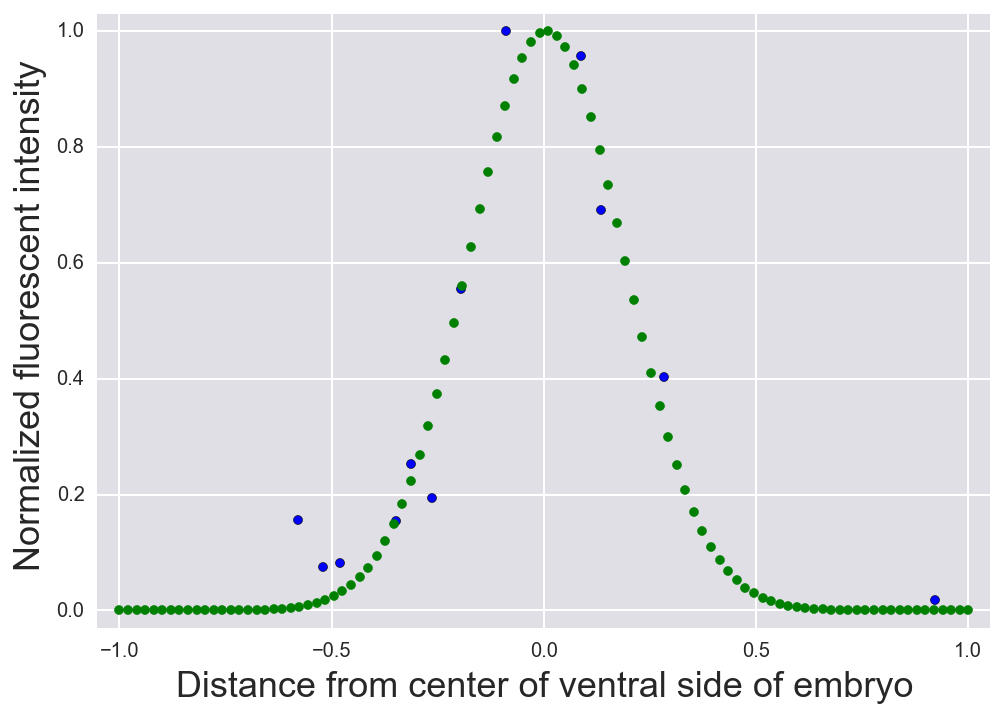

In [304]:
plt.scatter(df['DV coord nc 12'],((df['fluor intensity nc 12']-1)/ (np.max(df['fluor intensity nc 12'])-1)))
x = np.linspace(-1,1,100)
plt.scatter(x,gauss_dist(popt,x), color = 'green')
plt.margins(y=0.02)
plt.margins(x=0.02)
plt.xlabel('Distance from center of ventral side of embryo')
plt.ylabel(' Normalized fluorescent intensity')


In [305]:
# Instantiate Hessian for log posterior
hes_fun = ndt.Hessian(log_post)

# Compute Hessian at MAP
hes = hes_fun(popt, df_12['DV coord nc 12'],df_12['fluor intensity nc 12'])

# Compute the covariance matrix
cov = -np.linalg.inv(hes)

# Report results
print("""
Results for Nuclear cycle 12(≈ 68% of total probability)
------------------------------------------------
b = {0:.3f} ± {1:.3f}
c = {2:.3f} ± {3:.3f}
""".format(b, np.sqrt(cov[0,0]), c, np.sqrt(cov[1,1])))


Results for Nuclear cycle 12(≈ 68% of total probability)
------------------------------------------------
b = 0.006 ± nan
c = 0.184 ± 0.075



In [306]:
df_11 = pd.DataFrame({'DV coord nc 11': df['DV coord nc 11'], 'fluor intensity nc 11': (df['fluor intensity nc 11']-1)/ (np.max(df['fluor intensity nc 12'])-1)})
df_11 = df_11.dropna()

#Parameter values to plot
b = np.linspace(-.1, .1, 50)
c = np.linspace(.01, .5, 50)

# Make a grid
bb, cc = np.meshgrid(b, c)

# Compute log posterior
log_posterior = np.empty_like(bb)
for j in range(len(bb)):
    for i in range(len(cc)):
        log_posterior[i, j] = log_post(np.array([bb[i,j], cc[i,j]]), df_11['DV coord nc 11'], df_11['fluor intensity nc 11'])


# Initial guess
# b is the center of the distrubution, so we'll guess 0
# c is the spread
p0 = np.array([0, 0.2])

# Extra arguments as a tuple
args = (df_11['DV coord nc 11'],df_11['fluor intensity nc 11'])

# Compute the MAP
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)
# Extract the values
b,c = popt

# Print results
print("""
Nuclear cycle 1, most probable parameters
----------------------------------
b = {0:.3f} 
c = {1:.3f}
""".format(b, c))


Nuclear cycle 1, most probable parameters
----------------------------------
b = 0.016 
c = 0.115



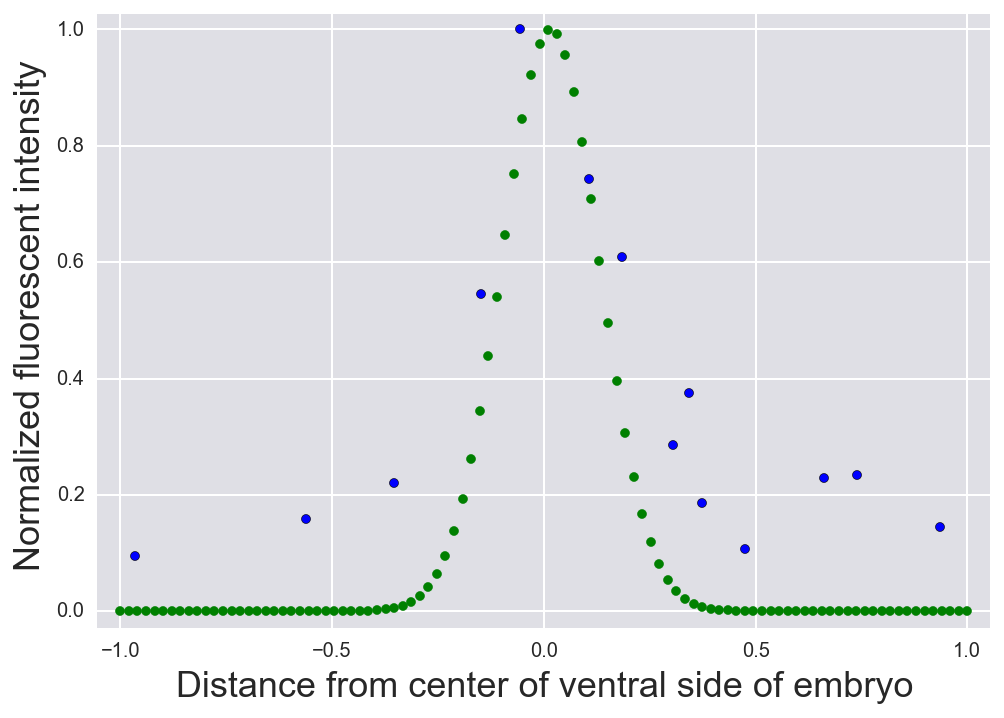

In [307]:
plt.scatter(df['DV coord nc 11'],((df['fluor intensity nc 11']-1)/ (np.max(df['fluor intensity nc 11'])-1)))
x = np.linspace(-1,1,100)
plt.scatter(x,gauss_dist(popt,x), color = 'green')
plt.margins(y=0.02)
plt.margins(x=0.02)
plt.xlabel('Distance from center of ventral side of embryo')
plt.ylabel(' Normalized fluorescent intensity')


In [308]:
# Instantiate Hessian for log posterior
hes_fun = ndt.Hessian(log_post)

# Compute Hessian at MAP
hes = hes_fun(popt, df_11['DV coord nc 11'],df_11['fluor intensity nc 11'])

# Compute the covariance matrix
cov = -np.linalg.inv(hes)

# Report results
print("""
Results for Nuclear cycle 11(≈ 68% of total probability)
------------------------------------------------
b = {0:.3f} ± {1:.3f}
c = {2:.3f} ± {3:.3f}
""".format(b, np.sqrt(cov[0,0]), c, np.sqrt(cov[1,1])))


Results for Nuclear cycle 11(≈ 68% of total probability)
------------------------------------------------
b = 0.016 ± 0.017
c = 0.115 ± 0.019



## 2d

In [309]:
# Load data
df = pd.read_csv('data/reeves_gradient_width_various_methods.csv', comment='#',header=[0,1])

# Check it out
df.head()

wt                dl1/+; dl-venus/+                          \
  wholemounts cross-sections       anti-Dorsal anti-Venus Venus (live)   
0      0.1288         0.1327            0.1482     0.1632       0.1666   
1      0.1554         0.1457            0.1503     0.1671       0.1753   
2      0.1306         0.1447            0.1577     0.1704       0.1705   
3      0.1413         0.1282            0.1711     0.1779          NaN   
4      0.1557         0.1487            0.1342     0.1483          NaN   

  dl1/+; dl-gfp/+                      
      anti-Dorsal anti-GFP GFP (live)  
0          0.2248   0.2389     0.2412  
1          0.1891   0.2035     0.1942  
2          0.1705   0.1943     0.2186  
3          0.1735   0.2000     0.2104  
4          0.2135   0.2560     0.2463

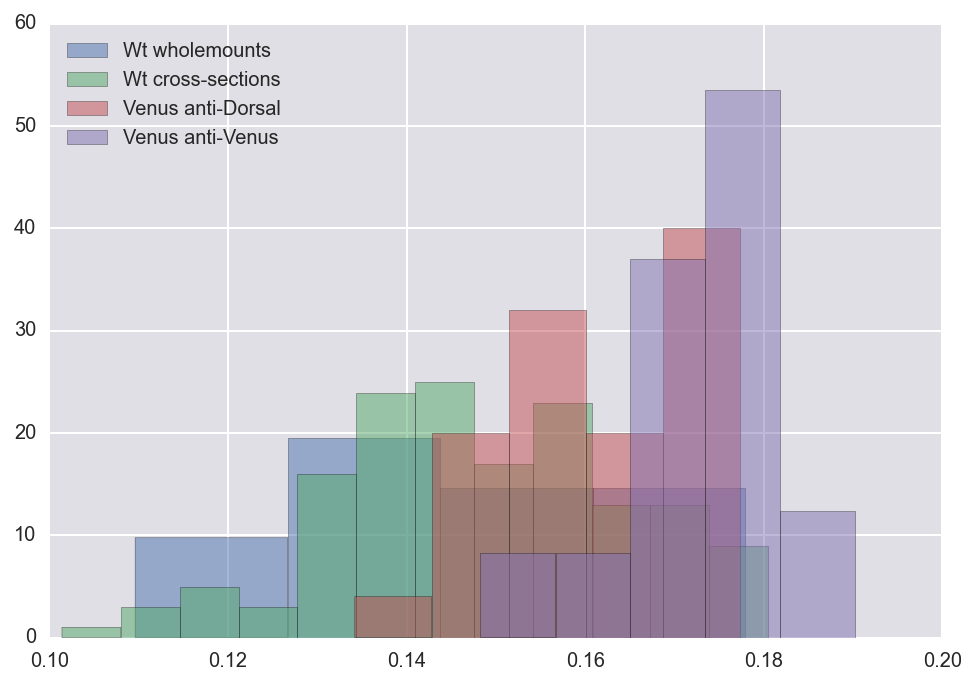

In [362]:
#I'm going to make a few histograms, becuase I think they are easier to
#see a shift in, rather than the boxplots, which the paper uses.


wholemounts= df['wt']['wholemounts'].dropna()
crosssection= df['wt']['cross-sections'].dropna()
venus_dorsal= df['dl1/+; dl-venus/+']['anti-Dorsal'].dropna()
venus_venus= df['dl1/+; dl-venus/+']['anti-Venus'].dropna()
venus_live= df['dl1/+; dl-venus/+']['Venus (live)'].dropna()
gfp_dorsal= df['dl1/+; dl-gfp/+']['anti-Dorsal'].dropna()
gfp_gfp= df['dl1/+; dl-gfp/+']['anti-GFP'].dropna()
gfp_live= df['dl1/+; dl-gfp/+']['GFP (live)'].dropna()


legend_labels = []
plt.hist(wholemounts, normed = True, alpha = .5, bins = np.sqrt(len(wholemounts)))
plt.hist(crosssection,normed = True, alpha =.5,bins = np.sqrt(len(crosssection)))
plt.hist(venus_dorsal,normed = True, alpha =.5, bins = np.sqrt(len(venus_dorsal)))
plt.hist(venus_venus,normed = True, alpha =.5, bins = np.sqrt(len(venus_venus)))
#plt.hist(venus_live, normed = True, alpha =.5)

legend_labels.append('Wt wholemounts')
legend_labels.append('Wt cross-sections')
legend_labels.append('Venus anti-Dorsal')
legend_labels.append('Venus anti-Venus')
plt.legend(legend_labels, loc='best')

## Histogram conclusions
No, it does not appear that the Venus fusion is a good approximation of the wild-type.  THe distributions are clearly shifted.

{'boxes': [<matplotlib.lines.Line2D at 0x1267b4320>,
 'caps': [<matplotlib.lines.Line2D at 0x1267b9710>,
 'fliers': [<matplotlib.lines.Line2D at 0x1267bfef0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1267bf710>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1267b46a0>,
  <matplotlib.lines.Line2D at 0x127136160>]}

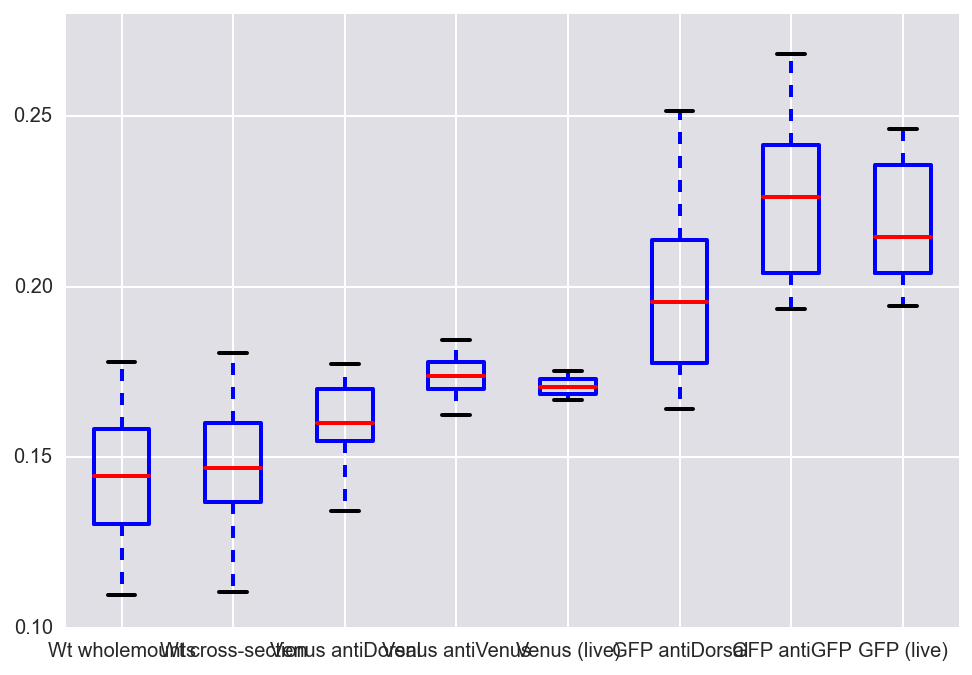

In [359]:
#  I only plotted 4 distributions, and it's getting hard to look at.
# Let's try the boxplot method, like in the paper

plt.boxplot([wholemounts, crosssection, venus_dorsal, venus_venus, venus_live, gfp_dorsal, gfp_gfp, gfp_live],labels=['Wt wholemounts','Wt cross-section','Venus antiDorsal','Venus antiVenus','Venus (live)','GFP antiDorsal','GFP antiGFP','GFP (live)'])




## Boxplot conclusions
The distributions are much easier to see in these boxplots because there are a lot of distributions that we need to see.  I guess the authors of the paper did a good job of plotting this stuff for clarity!
We can see that Venus fusions are not as bad as GFP fusions, but the distributions are still notably different from the Wt.
Now, not being a developmental biologist, I can't say whether the change in distribution actually means anything.  (I have no way of knowing if a 20% increase in the spread is important)  I'll assume that if it is a notable, measureable difference, then it is a poor model for the wild-type.
I guess it's not terribly surprising that fusing a ~350 amino acid fluorescent protein to another protein messes shit up; this is an incredibly well-documented phenomenon.  